In [1]:
from GenerateInhomogeneousPlaceCellSpikes import GenerateSpikes
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

### Testing a _homogeneous_ Poisson process.
#### Do we see that the simulated Fano Factor is 1?
For our first test, let's use a constant rate of spiking and a constant rate of running through the maze. We'll set it up so there's just one pass through the maze and a high rate so that we observe many spikes. We'll bin time and then ask about the mean and variance of spikes per bin.

In [2]:
def intensityFun(x,tlast) :
    return 40 * np.ones(np.size(x));

testNeuron = {'MaxRate': 40, 'IntensityFunction': intensityFun};

def posFun(t) :
    return t/20

TLength = 1000; # Length of experiment


In [3]:
SpikeTimes = GenerateSpikes(testNeuron["IntensityFunction"],testNeuron["MaxRate"], posFun, TLength);

BinSize = 1; # Seconds, so that intensity function and spike counts match in units!
TimeBins = np.arange(0,TLength+0.1,BinSize); # Need to add a little bit to account for end
BinnedSpikes,SpaceIdx = np.histogram(SpikeTimes, TimeBins);

# Mean and variance should be the same!
(np.mean(BinnedSpikes), np.var(BinnedSpikes))

39925


(39.924999999999997, 38.301375)

### Testing an _inhomogeneous_ Poisson Process
*Next let's actually make up a place field with non-uniform speed behavior and an inhomogeneous rate.*

We'll assume that the behavior is cosine-smooth from 0 to 1 and back. 

In [4]:
def posFun(t) :
    return (1 - np.cos(2*np.pi * t / 20))/2; # go from 0 to 1 meter in 20 s (and then back)

Let's make the place field Gaussian so that it will look nice. Note that this function will be called with a position vector and the history of (potential) spike times. These could be used to, e.g., impose a refractory period, but we won't do that here.

In [5]:
def intensityFun(x,thistory) :
    return 5*np.exp(-(x - 0.5)**2/(2 * 0.01));

Be careful in specifying the maximum firing rate. This needs to be equal-to or larger than the maximum value of the conditional intensity

In [6]:
testNeuron = {'MaxRate': 5, 'IntensityFunction': intensityFun};
    
TLength = 10000; # Simulate 10000 seconds (at 20 s per pass, this is 500 passes)
SpikeTimes = GenerateSpikes(testNeuron["IntensityFunction"],testNeuron["MaxRate"], posFun, TLength);

49907


To calculate empirical tuning curve, we will use "binned occupancy". To do this, we need to:
  - bin position as-a-function-of time (giving us total occupancy in seconds per spatial bin)
  - bin spikes as-a-function-of space (giving us total spikes per spatial bin)
  
Dividing these two will yield a *firing rate as a function of position* (which is the normal definition of a place field).

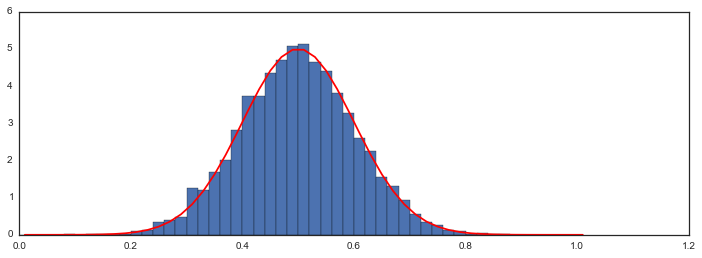

In [7]:
BehavioralSamplingRate = 100; # Camera frame rate is 100 Hz
tvec = np.arange(0,TLength+1/BehavioralSamplingRate,1/BehavioralSamplingRate);
BehavioralData = posFun(tvec); # This is his position as a function of time sampled at camera rate

# Set up spatial bins, and find spatial occupancy and spike occupancy
BinSize = 0.02; # This will be the bin size for the PSTH. 
                # Can't be smaller than camera rate because then those bins are zero
SpaceBins = np.arange(0,1 + BinSize/2,BinSize); # Need to add a little bit to account for end

BinnedBehavior,SpaceIdx = np.histogram(BehavioralData, SpaceBins);
BinnedSpikes,SpaceIdx = np.histogram(posFun(SpikeTimes), SpaceBins);

BinnedBehavioralTime = BinnedBehavior / BehavioralSamplingRate; # Behavior is sampled at 100 Hz, so time is 10ms bins
EmpiricalTuningCurve = BinnedSpikes / BinnedBehavioralTime;

sns.set(rc={'figure.figsize': (12,4)})
sns.set_style('white')
plt.bar(SpaceIdx[0:-1], EmpiricalTuningCurve, BinSize)
plt.plot(SpaceIdx + BinSize/2, intensityFun(SpaceIdx + BinSize/2,0), 'r-'); # Actually extends one extra bin!